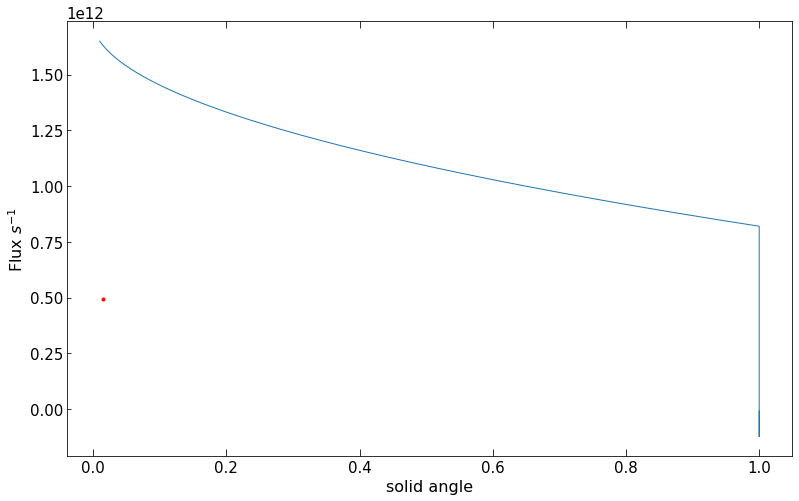

In [11]:
#********************************************************************
# Note: everything is converted to SI units unless printed otherwise
# takes into account the clamp
# fixed up mistakes from flux_calc10
# plot of the flux vs the various length of the tubes

# PURPOSE: SEE HOW THE FLUX FOR A SPECIFIC RADIUS CHANGES AS A FUNCTION OF THE 
#          FUDGE FACTOR PARAMETERS, SET TEMPERATURE TO THE MAXIMUM TEMP FROM
#          FROM PREVIOUS CURVE

#********************************************************************

#Global Constants
kB       = 1.38064852*10**(-23) # m^2 kg s^-2 K^-1 (boltzmann constant)
M        = 171*1.66054e-27      # mass of Yb in kg
sigma    = 1.5*10**(-19)        # cross sectional area of an atom

#Libraries
import matplotlib.pyplot as plt #plotting
import numpy as np
import matplotlib.pylab as pylab #plotting
import scipy.integrate as integrate #integrating
from numpy import sqrt, sin, cos, pi
from decimal import Decimal

#formatting plots
pylab.rcParams['figure.figsize'] = (13,8)
pylab.rcParams['figure.autolayout'] = False
pylab.rcParams.update({'axes.labelsize': 20})
pylab.rcParams.update({'xtick.labelsize': 15})
pylab.rcParams.update({'ytick.labelsize': 15})
pylab.rcParams.update({'lines.linewidth': 1.0})
pylab.rcParams.update({'axes.titlesize': 20.0})

pylab.rcParams.update({'ytick.direction': 'in'}) 
pylab.rcParams.update({'xtick.major.size': 7})   
pylab.rcParams.update({'xtick.direction': 'in'}) 
pylab.rcParams.update({'xtick.top': True}) 
pylab.rcParams.update({'xtick.minor.bottom': True}) 

plt.ylabel('Flux $s^{-1}$',fontsize=16)
plt.xlabel('solid angle', fontsize=16)

#Set Parameters
lowT = 350 
hghT = 600
lowL = .01
hghL = 10
steps = 1000 
len_algn_fud = 1                              # alignment fudge factor
h_clamp      = 2*10**(-3)                     # height of the clamp
radius = 7                      # Change this to change the radius you want to look at

#Dimensional Parameters of DPT (m)
R_DPT         = 2.5*10**(-3)                     # radius of DPT
L_to_DPT      = 518*10**(-3)                     # length from the end of nozzle to the end of DPT   
fud   = np.linspace(lowL, hghL, steps) 

# Our Current System
L_now = 12.7 * 10**(-3)
r_now = 0.5*10**(-3)
A_now = pi*r_now**2
N_now = 5


# outer diameter radius and inner array parameters picked from the sheet based on small wall thickness
rOD   = np.array([0.0425,0.0355,0.032,0.028,0.025,0.020,0.0163,0.012,0.008])*(0.0254/2) 
rID   = np.array([0.035 ,0.031 ,0.029,0.024,0.020,0.016,0.0120,0.008,0.006])*(0.0254/2) 
gauge = np.array(['19X','20XX','21XX','22XX','23XX','25XX','27X','30XX','33X'])    
dataT = np.array([400,450,500,545])
dataF = np.array([1.22*10**(9),4.2*10**(9),7.8*10**(9),9*10**(9)])

#*****************************************************************************************
# Calculating Dimensional Parameters
#*****************************************************************************************

# length and heigh calculation of the triangle
trngle_len    = 2*np.sqrt(3)*R_DPT       # length of the triangle to match DPT
h_trngle      = trngle_len*np.sqrt(3)/2  # height of the triangle to match DPT

# Number of tubes calculations
n             = trngle_len/(2*rOD[radius])                          # number of tubes along the side of the triangle
N_tubes       = n*(n+1)/2                                   # number of tubes, triangular numbers formula

# Area calculations
A_trngle      = (trngle_len**(2)*sqrt(3)/4)                 # area of triangle nozzle without tubes
A_open        = A_trngle - N_tubes*pi*(rOD[radius]**2 - rID[radius]**2)     # m^2, total open area of nozzle 
area_DPT      = pi*R_DPT**(2)                               # area of the DPT  

# Angle and length of tubes calculations
theta_DPT     = np.arctan(R_DPT/L_to_DPT)                   # maximum angle of atoms out of the DPT 
L_opt         = rID[radius]/(np.tan(theta_DPT))             # optimal length of tubes
L_opt_fud     = L_opt /fud                                  # fudged optimal length of tubes
L_to_DPT_fud  = L_to_DPT/fud                                # optimal length of tubes with fudge factor
theta_tubes   = np.arctan(R_DPT/L_to_DPT_fud)               # maximum angle out of tubes with fudged length
theta_mx      = np.arctan(r_now/L_now)

# Ratios - solid angle and the area ratio
r_sld_angles_fud =  sin(theta_DPT)**2*(1-(sin(theta_tubes))**2 )/((sin(theta_tubes))**2*(1-(sin(theta_DPT))**2 ) )     # Area Ratio of theta_DPT and theta_DPT_fud
# if ratio is smaller than one all the atoms are getting in and a ratio should not be taken

for i in range(0,len(r_sld_angles_fud)):
    if r_sld_angles_fud[i] > 1:
        r_sld_angles_fud[i] = 1

area_ratio       = area_DPT/A_trngle                       # Area Ratio
r_sld_angles_now = sin(theta_DPT)**2*(1-(sin(theta_mx))**2 )/((sin(theta_mx))**2*(1-(sin(theta_DPT))**2 ) )

# trapezoidal calculations for the clamp dimensions
clamp_lid_len = trngle_len + 2*h_clamp/(np.sqrt(3))
side_clamp    = np.sqrt(h_clamp**(2)+ h_clamp**(2)/3)

#*****************************************************************************************
# Calculating Temperature Parameters - all scalars
#*****************************************************************************************

# Convert set temperature in Celcius to Kelvin
T_oven   = 470 # set oven temp to be the maximum flux oven temp 
T        = T_oven + 273

# Quantities which all Depend on temperature: pressure, density, velocity
P        = 10**(5.006 + 9.111 - 8111/T -1.0849*np.log10(T)) # pressure calculation
v_tilde  = np.sqrt(kB*T/M)                                  # convenient redefinition
n_0      = P/(kB*T)                                         # Number of atoms per Volume
v_mp     = np.sqrt(2)*v_tilde                               # most probable velocity
v_avg    = np.sqrt(8/(np.pi))*v_tilde                       # avergae velocity
v_rms    = np.sqrt(3)*v_tilde                               # root-mean-square velocity
MFP      = 1/(n_0*sigma*sqrt(2))                            # mean free path of the atoms

#*****************************************************************************************
# Flux Calculations
#*****************************************************************************************

# Integration
I       = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT)     # integration for the ideal numbers

# Integration array, integrate for each possible theta_tubes due to the length variation
I_result_fud = np.array([])
for i in range (0,len(fud)):
    I_fud        = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_tubes[i])
    I_elmnt_fud  = I_fud[0]
    I_result_fud = np.append(I_result_fud, I_elmnt_fud) 

I_now   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_mx)

# Fractional amount of atoms get through
f = L_opt_fud/MFP 

# fractional amount of atoms getting through for our system
f_now  = L_now/MFP

Flux_noz_new = A_open*v_mp*n_0*I_result_fud*(1-f)*area_ratio
Flux_DPT_fud = A_open*v_mp*n_0*(1-f)*r_sld_angles_fud*area_ratio*I_result_fud

# total flux of our current system after DPT
Flux_now_DPT = N_now*A_now*n_0*v_mp*I_now[0]*r_sld_angles_now*(1-f_now) 

# total flux of our system after the nozzle
Flux_noz_old = N_now*A_now*n_0*I_now[0]*(1-f_now)*v_mp 

#***************************************************************************
#  Plotting STuff
#***************************************************************************

#plt.plot(fud,Flux_DPT_fud )
plt.plot(r_sld_angles_fud ,Flux_DPT_fud)
plt.plot(r_sld_angles_now,Flux_now_DPT ,'r.')

# minimum and maximum values on the plot
plt.ylim()
plt.xlim()
#plt.yscale('log')
#plt.title('The Flux After the Nozzle')

pylab.savefig('solidvsflux.pdf', format='pdf', dpi=1000,bbox_inches='tight')
